### Cab-Driver Agent

In [36]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [37]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [38]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [39]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size
        #Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = -0.0005 #for 15k
        #self.epsilon_decay = -0.00015 #for 20k
        self.epsilon_min = 0.00001
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state, possible_actions_index, actions):        
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment 

        # get action from model using epsilon-greedy policy
        # Decay in ε after each episode       
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from the ride requests
            return random.choice(possible_actions_index)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)

            # Use the model to predict the Q_values.
            q_value = self.model.predict(state)

            # truncate the array to only those actions that are part of the ride  requests.
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]

            return possible_actions_index[np.argmax(q_vals_possible)]

    def append_sample(self, state, action_index, reward, next_state, done):
        self.memory.append((state, action_index, reward, next_state, done))
        
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            # populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)

            # predict the target q-values from states s
            target = self.model.predict(update_input)
            # target for q-network
            target_qval = self.model.predict(update_output)


            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)


    def save(self, name):
        self.model.save(name)

In [40]:
episode_time = 24*30 #30 days before which car has to be recharged
n_episodes = 15000
m = 5
t = 24
d = 7

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = m+t+d
action_size = len(action_space)

# Invoke agent class
agent = DQNAgent(action_size=action_size, state_size=state_size)

# to store rewards in each episode
rewards_per_episode, episodes = [], []
# Rewards for state [0,0,0] being tracked.
rewards_init_state = []

### DQN block

In [41]:
start_time = time.time()
score_tracked = []

for episode in range(n_episodes):

    done = False
    score = 0
    track_reward = False

    # reset at the start of each episode
    env = CabDriver()
    action_space, state_space, state = env.reset()
    # Save the initial state so that reward can be tracked if initial state is [0,0,0]
    initial_state = env.state_init
    #print(state)


    total_time = 0  # Total time driver rode in this episode
    while not done:
        # 1. Get a list of the ride requests driver got.
        possible_actions_indices, actions = env.requests(state)        
        
        # 2. Pick epsilon-greedy action from possible actions for the current state.
        action = agent.get_action(state, possible_actions_indices, actions)

        # 3. Evaluate your reward and next state
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
        # 4. Total time driver rode in this episode
        total_time += step_time
        if (total_time > episode_time):
            # if ride does not complete in stipu;ated time skip
            # it and move to next episode.
            done = True
        else:
            # 5. Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, done)
            # 6. Train the model by calling function agent.train_model
            agent.train_model()
            # 7. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
    

    # epsilon decay
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)

    # every 10 episodes:
    if ((episode + 1) % 10 == 0):
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon, total_time))
    

    # Total rewards per episode
    score_tracked.append(score)

    if(episode % 1000 == 0):
        print("Saving Model {}".format(episode))
        agent.save(name="model_weights.pkl")
    
elapsed_time = time.time() - start_time
print(elapsed_time)

Saving Model 0
episode 9, reward 70.0, memory_length 1412, epsilon 0.9955001547284723 total_time 732.0
episode 19, reward -188.0, memory_length 2000, epsilon 0.9905350769930761 total_time 728.0
episode 29, reward -194.0, memory_length 2000, epsilon 0.9855947626861951 total_time 724.0
episode 39, reward -252.0, memory_length 2000, epsilon 0.9806790882997144 total_time 726.0
episode 49, reward 1.0, memory_length 2000, epsilon 0.9757879309415182 total_time 723.0
episode 59, reward -326.0, memory_length 2000, epsilon 0.9709211683324178 total_time 722.0
episode 69, reward -18.0, memory_length 2000, epsilon 0.9660786788030947 total_time 727.0
episode 79, reward -115.0, memory_length 2000, epsilon 0.9612603412910584 total_time 725.0
episode 89, reward 50.0, memory_length 2000, epsilon 0.9564660353376199 total_time 722.0
episode 99, reward 18.0, memory_length 2000, epsilon 0.9516956410848808 total_time 728.0
episode 109, reward -70.0, memory_length 2000, epsilon 0.9469490392727365 total_time 7

episode 919, reward 279.0, memory_length 2000, epsilon 0.631593050259626 total_time 721.0
episode 929, reward 18.0, memory_length 2000, epsilon 0.6284429667796988 total_time 726.0
episode 939, reward 204.0, memory_length 2000, epsilon 0.6253085944066726 total_time 723.0
episode 949, reward 218.0, memory_length 2000, epsilon 0.6221898547810748 total_time 722.0
episode 959, reward 458.0, memory_length 2000, epsilon 0.6190866699342522 total_time 728.0
episode 969, reward 486.0, memory_length 2000, epsilon 0.6159989622864221 total_time 722.0
episode 979, reward 594.0, memory_length 2000, epsilon 0.6129266546447325 total_time 721.0
episode 989, reward 947.0, memory_length 2000, epsilon 0.6098696702013323 total_time 725.0
episode 999, reward 321.0, memory_length 2000, epsilon 0.6068279325314512 total_time 723.0
Saving Model 1000
episode 1009, reward 315.0, memory_length 2000, epsilon 0.6038013655914889 total_time 727.0
episode 1019, reward 253.0, memory_length 2000, epsilon 0.600789893717114

episode 1809, reward 372.0, memory_length 2000, epsilon 0.40474015917966877 total_time 726.0
episode 1819, reward 660.0, memory_length 2000, epsilon 0.4027215092142031 total_time 722.0
episode 1829, reward 1063.0, memory_length 2000, epsilon 0.4007129273074429 total_time 730.0
episode 1839, reward 1036.0, memory_length 2000, epsilon 0.39871436324473586 total_time 725.0
episode 1849, reward 687.0, memory_length 2000, epsilon 0.3967257670618763 total_time 723.0
episode 1859, reward 856.0, memory_length 2000, epsilon 0.3947470890438561 total_time 729.0
episode 1869, reward 1044.0, memory_length 2000, epsilon 0.3927782797236218 total_time 727.0
episode 1879, reward 819.0, memory_length 2000, epsilon 0.3908192898808378 total_time 727.0
episode 1889, reward 657.0, memory_length 2000, epsilon 0.388870070540656 total_time 726.0
episode 1899, reward 719.0, memory_length 2000, epsilon 0.38693057297249134 total_time 724.0
episode 1909, reward 384.0, memory_length 2000, epsilon 0.3850007486888037 

episode 2699, reward 1008.0, memory_length 2000, epsilon 0.25936731948751673 total_time 728.0
episode 2709, reward 1024.0, memory_length 2000, epsilon 0.2580737195848345 total_time 726.0
episode 2719, reward 1185.0, memory_length 2000, epsilon 0.25678657153858325 total_time 725.0
episode 2729, reward 873.0, memory_length 2000, epsilon 0.2555058431699948 total_time 721.0
episode 2739, reward 932.0, memory_length 2000, epsilon 0.25423150246079323 total_time 725.0
episode 2749, reward 1260.0, memory_length 2000, epsilon 0.2529635175523944 total_time 729.0
episode 2759, reward 1040.0, memory_length 2000, epsilon 0.25170185674510953 total_time 725.0
episode 2769, reward 1154.0, memory_length 2000, epsilon 0.25044648849735274 total_time 722.0
episode 2779, reward 1332.0, memory_length 2000, epsilon 0.2491973814248526 total_time 724.0
episode 2789, reward 1224.0, memory_length 2000, epsilon 0.24795450429986704 total_time 721.0
episode 2799, reward 995.0, memory_length 2000, epsilon 0.24671782

episode 3579, reward 1089.0, memory_length 2000, epsilon 0.16704200018866794 total_time 725.0
episode 3589, reward 1482.0, memory_length 2000, epsilon 0.166208874737031 total_time 725.0
episode 3599, reward 1348.0, memory_length 2000, epsilon 0.1653799045159192 total_time 721.0
episode 3609, reward 1233.0, memory_length 2000, epsilon 0.16455506880103385 total_time 722.0
episode 3619, reward 1186.0, memory_length 2000, epsilon 0.1637343469714391 total_time 722.0
episode 3629, reward 801.0, memory_length 2000, epsilon 0.1629177185090465 total_time 729.0
episode 3639, reward 1326.0, memory_length 2000, epsilon 0.16210516299810185 total_time 722.0
episode 3649, reward 1247.0, memory_length 2000, epsilon 0.16129666012467522 total_time 724.0
episode 3659, reward 1233.0, memory_length 2000, epsilon 0.16049218967615253 total_time 722.0
episode 3669, reward 878.0, memory_length 2000, epsilon 0.15969173154073077 total_time 725.0
episode 3679, reward 1221.0, memory_length 2000, epsilon 0.15889526

episode 4459, reward 1396.0, memory_length 2000, epsilon 0.10758113197207911 total_time 722.0
episode 4469, reward 1397.0, memory_length 2000, epsilon 0.10704456883789358 total_time 725.0
episode 4479, reward 1603.0, memory_length 2000, epsilon 0.10651068182350425 total_time 723.0
episode 4489, reward 1341.0, memory_length 2000, epsilon 0.10597945758170793 total_time 728.0
episode 4499, reward 1369.0, memory_length 2000, epsilon 0.10545088283187094 total_time 724.0
episode 4509, reward 1361.0, memory_length 2000, epsilon 0.10492494435959693 total_time 722.0
episode 4519, reward 1632.0, memory_length 2000, epsilon 0.1044016290163968 total_time 721.0
episode 4529, reward 1414.0, memory_length 2000, epsilon 0.10388092371935967 total_time 721.0
episode 4539, reward 1476.0, memory_length 2000, epsilon 0.103362815450826 total_time 721.0
episode 4549, reward 1139.0, memory_length 2000, epsilon 0.10284729125806202 total_time 721.0
episode 4559, reward 1620.0, memory_length 2000, epsilon 0.1023

episode 5339, reward 1233.0, memory_length 2000, epsilon 0.06928616721137094 total_time 721.0
episode 5349, reward 1598.0, memory_length 2000, epsilon 0.06894060101074494 total_time 729.0
episode 5359, reward 1576.0, memory_length 2000, epsilon 0.06859675832873488 total_time 721.0
episode 5369, reward 1755.0, memory_length 2000, epsilon 0.06825463056925578 total_time 727.0
episode 5379, reward 1393.0, memory_length 2000, epsilon 0.06791420917909581 total_time 721.0
episode 5389, reward 1620.0, memory_length 2000, epsilon 0.06757548564770255 total_time 726.0
episode 5399, reward 1374.0, memory_length 2000, epsilon 0.06723845150697004 total_time 729.0
episode 5409, reward 1400.0, memory_length 2000, epsilon 0.06690309833102723 total_time 723.0
episode 5419, reward 1391.0, memory_length 2000, epsilon 0.06656941773602718 total_time 725.0
episode 5429, reward 1599.0, memory_length 2000, epsilon 0.06623740137993772 total_time 723.0
episode 5439, reward 1663.0, memory_length 2000, epsilon 0.0

episode 6209, reward 1673.0, memory_length 2000, epsilon 0.04484648795318105 total_time 723.0
episode 6219, reward 1698.0, memory_length 2000, epsilon 0.04462281516137944 total_time 724.0
episode 6229, reward 1404.0, memory_length 2000, epsilon 0.044400257942280974 total_time 726.0
episode 6239, reward 1787.0, memory_length 2000, epsilon 0.04417881073194358 total_time 724.0
episode 6249, reward 1373.0, memory_length 2000, epsilon 0.04395846799417545 total_time 725.0
episode 6259, reward 1341.0, memory_length 2000, epsilon 0.043739224220396694 total_time 721.0
episode 6269, reward 1608.0, memory_length 2000, epsilon 0.04352107392950154 total_time 721.0
episode 6279, reward 1060.0, memory_length 2000, epsilon 0.04330401166772134 total_time 723.0
episode 6289, reward 1458.0, memory_length 2000, epsilon 0.04308803200848826 total_time 721.0
episode 6299, reward 1505.0, memory_length 2000, epsilon 0.042873129552299535 total_time 725.0
episode 6309, reward 1594.0, memory_length 2000, epsilon 

episode 7079, reward 1460.0, memory_length 2000, epsilon 0.029027547094634832 total_time 727.0
episode 7089, reward 1216.0, memory_length 2000, epsilon 0.02888277159951494 total_time 729.0
episode 7099, reward 1558.0, memory_length 2000, epsilon 0.028738718175189356 total_time 727.0
episode 7109, reward 1626.0, memory_length 2000, epsilon 0.028595383220314963 total_time 723.0
episode 7119, reward 1255.0, memory_length 2000, epsilon 0.02845276315151042 total_time 726.0
episode 7129, reward 1359.0, memory_length 2000, epsilon 0.028310854403266573 total_time 731.0
episode 7139, reward 1220.0, memory_length 2000, epsilon 0.028169653427857343 total_time 721.0
episode 7149, reward 911.0, memory_length 2000, epsilon 0.028029156695250978 total_time 722.0
episode 7159, reward 1203.0, memory_length 2000, epsilon 0.027889360693021847 total_time 722.0
episode 7169, reward 1283.0, memory_length 2000, epsilon 0.027750261926262603 total_time 726.0
episode 7179, reward 1638.0, memory_length 2000, epsi

episode 7949, reward 1247.0, memory_length 2000, epsilon 0.018788505606300788 total_time 727.0
episode 7959, reward 1252.0, memory_length 2000, epsilon 0.01869479754365095 total_time 722.0
episode 7969, reward 1845.0, memory_length 2000, epsilon 0.0186015568519134 total_time 721.0
episode 7979, reward 1422.0, memory_length 2000, epsilon 0.018508781200065983 total_time 730.0
episode 7989, reward 1539.0, memory_length 2000, epsilon 0.018416468268712564 total_time 723.0
episode 7999, reward 1017.0, memory_length 2000, epsilon 0.018324615750025048 total_time 721.0
Saving Model 8000
episode 8009, reward 1032.0, memory_length 2000, epsilon 0.018233221347685697 total_time 723.0
episode 8019, reward 1379.0, memory_length 2000, epsilon 0.018142282776829687 total_time 722.0
episode 8029, reward 1306.0, memory_length 2000, epsilon 0.01805179776398801 total_time 729.0
episode 8039, reward 1512.0, memory_length 2000, epsilon 0.01796176404703063 total_time 726.0
episode 8049, reward 1324.0, memory_l

episode 8819, reward 1440.0, memory_length 2000, epsilon 0.012161135826156058 total_time 722.0
episode 8829, reward 1107.0, memory_length 2000, epsilon 0.01210048190818249 total_time 721.0
episode 8839, reward 1513.0, memory_length 2000, epsilon 0.01204013050288686 total_time 721.0
episode 8849, reward 1440.0, memory_length 2000, epsilon 0.011980080101480892 total_time 725.0
episode 8859, reward 1548.0, memory_length 2000, epsilon 0.011920329202701425 total_time 723.0
episode 8869, reward 1296.0, memory_length 2000, epsilon 0.011860876312772876 total_time 721.0
episode 8879, reward 1596.0, memory_length 2000, epsilon 0.011801719945369903 total_time 724.0
episode 8889, reward 1634.0, memory_length 2000, epsilon 0.011742858621580235 total_time 725.0
episode 8899, reward 1487.0, memory_length 2000, epsilon 0.011684290869867704 total_time 723.0
episode 8909, reward 1443.0, memory_length 2000, epsilon 0.011626015226035489 total_time 724.0
episode 8919, reward 1738.0, memory_length 2000, eps

episode 9689, reward 1460.0, memory_length 2000, epsilon 0.007871473531807663 total_time 721.0
episode 9699, reward 1417.0, memory_length 2000, epsilon 0.007832214393783524 total_time 724.0
episode 9709, reward 1398.0, memory_length 2000, epsilon 0.007793151061527156 total_time 725.0
episode 9719, reward 1442.0, memory_length 2000, epsilon 0.00775428255845322 total_time 729.0
episode 9729, reward 1572.0, memory_length 2000, epsilon 0.007715607912847108 total_time 721.0
episode 9739, reward 1116.0, memory_length 2000, epsilon 0.007677126157840679 total_time 722.0
episode 9749, reward 1212.0, memory_length 2000, epsilon 0.007638836331388046 total_time 727.0
episode 9759, reward 1373.0, memory_length 2000, epsilon 0.007600737476241555 total_time 727.0
episode 9769, reward 1332.0, memory_length 2000, epsilon 0.007562828639927842 total_time 732.0
episode 9779, reward 1298.0, memory_length 2000, epsilon 0.007525108874724024 total_time 722.0
episode 9789, reward 1235.0, memory_length 2000, ep

episode 10549, reward 1194.0, memory_length 2000, epsilon 0.005120465121314752 total_time 728.0
episode 10559, reward 1154.0, memory_length 2000, epsilon 0.005094926694979046 total_time 724.0
episode 10569, reward 1503.0, memory_length 2000, epsilon 0.00506951564207608 total_time 722.0
episode 10579, reward 1171.0, memory_length 2000, epsilon 0.005044231327328204 total_time 723.0
episode 10589, reward 1398.0, memory_length 2000, epsilon 0.005019073118626231 total_time 721.0
episode 10599, reward 1277.0, memory_length 2000, epsilon 0.004994040387013635 total_time 722.0
episode 10609, reward 841.0, memory_length 2000, epsilon 0.00496913250667082 total_time 722.0
episode 10619, reward 1359.0, memory_length 2000, epsilon 0.004944348854899481 total_time 728.0
episode 10629, reward 1251.0, memory_length 2000, epsilon 0.004919688812107034 total_time 729.0
episode 10639, reward 1027.0, memory_length 2000, epsilon 0.004895151761791122 total_time 722.0
episode 10649, reward 990.0, memory_length 

episode 11409, reward 664.0, memory_length 2000, epsilon 0.0033309091306287742 total_time 726.0
episode 11419, reward 1079.0, memory_length 2000, epsilon 0.0033142961520324795 total_time 724.0
episode 11429, reward 1257.0, memory_length 2000, epsilon 0.0032977660310126045 total_time 725.0
episode 11439, reward 1613.0, memory_length 2000, epsilon 0.0032813183543152643 total_time 731.0
episode 11449, reward 1406.0, memory_length 2000, epsilon 0.003264952710747684 total_time 722.0
episode 11459, reward 1629.0, memory_length 2000, epsilon 0.003248668691167922 total_time 721.0
episode 11469, reward 1127.0, memory_length 2000, epsilon 0.0032324658884746406 total_time 724.0
episode 11479, reward 1125.0, memory_length 2000, epsilon 0.0032163438975969265 total_time 724.0
episode 11489, reward 1656.0, memory_length 2000, epsilon 0.0032003023154841726 total_time 721.0
episode 11499, reward 1595.0, memory_length 2000, epsilon 0.0031843407410959887 total_time 721.0
episode 11509, reward 1694.0, mem

episode 12269, reward 897.0, memory_length 2000, epsilon 0.0021667866831709542 total_time 721.0
episode 12279, reward 1148.0, memory_length 2000, epsilon 0.00215597978950362 total_time 722.0
episode 12289, reward 1341.0, memory_length 2000, epsilon 0.0021452267954433146 total_time 721.0
episode 12299, reward 1035.0, memory_length 2000, epsilon 0.002134527432164626 total_time 727.0
episode 12309, reward 1252.0, memory_length 2000, epsilon 0.002123881432182913 total_time 730.0
episode 12319, reward 1211.0, memory_length 2000, epsilon 0.0021132885293476253 total_time 727.0
episode 12329, reward 918.0, memory_length 2000, epsilon 0.002102748458835638 total_time 723.0
episode 12339, reward 1009.0, memory_length 2000, epsilon 0.0020922609571446408 total_time 723.0
episode 12349, reward 1274.0, memory_length 2000, epsilon 0.0020818257620865434 total_time 725.0
episode 12359, reward 1459.0, memory_length 2000, epsilon 0.0020714426127809273 total_time 722.0
episode 12369, reward 743.0, memory_l

episode 13119, reward 1292.0, memory_length 2000, epsilon 0.0014165796642788893 total_time 721.0
episode 13129, reward 882.0, memory_length 2000, epsilon 0.0014095144437280755 total_time 721.0
episode 13139, reward 1142.0, memory_length 2000, epsilon 0.0014024844611117656 total_time 724.0
episode 13149, reward 1225.0, memory_length 2000, epsilon 0.0013954895406800313 total_time 723.0
episode 13159, reward 1292.0, memory_length 2000, epsilon 0.0013885295075594956 total_time 721.0
episode 13169, reward 1357.0, memory_length 2000, epsilon 0.001381604187748968 total_time 721.0
episode 13179, reward 964.0, memory_length 2000, epsilon 0.001374713408115093 total_time 727.0
episode 13189, reward 1202.0, memory_length 2000, epsilon 0.0013678569963880207 total_time 725.0
episode 13199, reward 1443.0, memory_length 2000, epsilon 0.0013610347811571003 total_time 725.0
episode 13209, reward 510.0, memory_length 2000, epsilon 0.0013542465918665965 total_time 732.0
episode 13219, reward 833.0, memory

episode 13969, reward 1061.0, memory_length 2000, epsilon 0.0009261169827349209 total_time 722.0
episode 13979, reward 1059.0, memory_length 2000, epsilon 0.0009214979550135194 total_time 723.0
episode 13989, reward 1292.0, memory_length 2000, epsilon 0.0009169019647889888 total_time 725.0
episode 13999, reward 1186.0, memory_length 2000, epsilon 0.0009123288971613334 total_time 722.0
Saving Model 14000
episode 14009, reward 1212.0, memory_length 2000, epsilon 0.0009077786378036242 total_time 723.0
episode 14019, reward 1254.0, memory_length 2000, epsilon 0.0009032510729591402 total_time 722.0
episode 14029, reward 1269.0, memory_length 2000, epsilon 0.0008987460894385246 total_time 724.0
episode 14039, reward 1135.0, memory_length 2000, epsilon 0.0008942635746169547 total_time 724.0
episode 14049, reward 1231.0, memory_length 2000, epsilon 0.0008898034164313264 total_time 726.0
episode 14059, reward 1657.0, memory_length 2000, epsilon 0.0008853655033774521 total_time 722.0
episode 140

episode 14819, reward 1593.0, memory_length 2000, epsilon 0.0006054673008077113 total_time 728.0
episode 14829, reward 1199.0, memory_length 2000, epsilon 0.0006024475200467823 total_time 721.0
episode 14839, reward 1467.0, memory_length 2000, epsilon 0.0005994428005052322 total_time 721.0
episode 14849, reward 1288.0, memory_length 2000, epsilon 0.0005964530670649156 total_time 728.0
episode 14859, reward 1117.0, memory_length 2000, epsilon 0.0005934782449823409 total_time 724.0
episode 14869, reward 1271.0, memory_length 2000, epsilon 0.0005905182598868013 total_time 722.0
episode 14879, reward 1499.0, memory_length 2000, epsilon 0.0005875730377785148 total_time 721.0
episode 14889, reward 1042.0, memory_length 2000, epsilon 0.0005846425050267752 total_time 722.0
episode 14899, reward 943.0, memory_length 2000, epsilon 0.0005817265883681118 total_time 726.0
episode 14909, reward 910.0, memory_length 2000, epsilon 0.000578825214904456 total_time 721.0
episode 14919, reward 1262.0, mem

In [42]:
###fetching from saved pickle file
#objects = []
#with (open("model_weights.pkl", "rb")) as openfile:
    #while True:
        #try:
            #objects.append(pickle.load(openfile))
        #except EOFError:
            #break

In [43]:
print(rewards_per_episode)

[19.0, -484.0, -195.0, -450.0, -243.0, -183.0, -130.0, 14.0, 96.0, 70.0, -125.0, -337.0, -67.0, -548.0, -231.0, -120.0, -202.0, -376.0, -140.0, -188.0, -197.0, 77.0, -21.0, -405.0, -313.0, -385.0, 99.0, -535.0, -89.0, -194.0, -153.0, -373.0, -199.0, -389.0, -313.0, -102.0, -107.0, -328.0, -191.0, -252.0, -229.0, -225.0, -493.0, -72.0, -283.0, -125.0, 92.0, -36.0, -234.0, 1.0, 105.0, -300.0, -229.0, -117.0, -281.0, 105.0, -561.0, -313.0, -255.0, -326.0, -350.0, -9.0, -12.0, -108.0, -8.0, 25.0, 37.0, -107.0, -185.0, -18.0, -180.0, -271.0, -59.0, -197.0, -238.0, -368.0, -213.0, -319.0, -426.0, -115.0, -391.0, -103.0, 104.0, -163.0, -399.0, -51.0, -197.0, -206.0, -219.0, 50.0, 37.0, -255.0, -603.0, -85.0, -255.0, -255.0, 9.0, -277.0, -175.0, 18.0, -328.0, 261.0, -393.0, -54.0, -73.0, 203.0, 334.0, -435.0, -239.0, -70.0, 140.0, -378.0, -252.0, -155.0, 207.0, -74.0, -423.0, 68.0, -192.0, 180.0, -71.0, -66.0, -370.0, 5.0, 43.0, 9.0, -99.0, 18.0, -27.0, -39.0, -393.0, -222.0, -208.0, -145.0, -

### Tracking Convergence

<function matplotlib.pyplot.show(*args, **kw)>

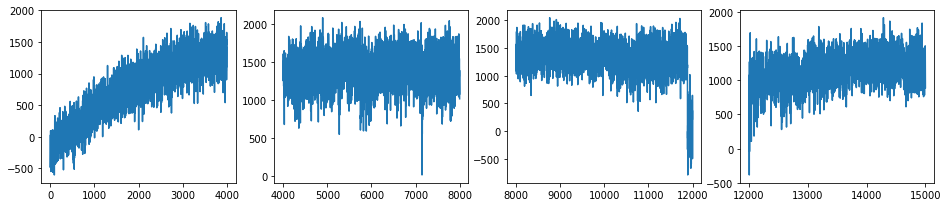

In [44]:
plt.figure(0, figsize=(16,7))

xaxis = np.asarray(range(0, 4000))
plt.subplot(241)
plt.plot(xaxis,np.asarray(rewards_per_episode[0:4000]))
plt.show

xaxis = np.asarray(range(4000, 8000))
plt.subplot(242)
plt.plot(xaxis,np.asarray(rewards_per_episode[4000:8000]))
plt.show

xaxis = np.asarray(range(8000, 12000))
plt.subplot(243)
plt.plot(xaxis,np.asarray(rewards_per_episode[8000:12000]))
plt.show


xaxis = np.asarray(range(12000, 15000))
plt.subplot(244)
plt.plot(xaxis,np.asarray(rewards_per_episode[12000:15000]))
plt.show


<function matplotlib.pyplot.show(*args, **kw)>

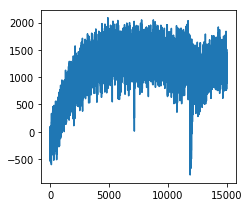

In [45]:
# Graph for all rewards per episodes.

plt.figure(0, figsize=(16,7))

xaxis = np.asarray(range(0, len(rewards_per_episode)))
plt.subplot(241)
plt.plot(xaxis,np.asarray(rewards_per_episode))
plt.show

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [46]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

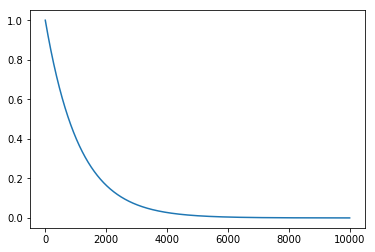

In [47]:
plt.plot(time, epsilon)
plt.show()